# Summarize

## Import Libraries

In [5]:
import boto3
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import importlib.util
from botocore.exceptions import ClientError


#from io import BytesIO
from io import StringIO

import configparser
import sys
import os

/Users/bernd/Documents/Own_Projects/articles_summary/nlpenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Create an aws session

In [6]:
def create_aws_session(profile_name='py_admin'):
    try:
        session = boto3.Session(profile_name=profile_name)
        return session
    except Exception as e:
        print(f"Error creating session for profile {profile_name}: {e}")
        return None

# Use the py_admin profile
session = create_aws_session()


# Initialize S3 client
s3 = session.client('s3')

### S3 Methods

In [7]:
def download_csv_content_from_s3(bucket, key, encoding, s3_client):
    """
    Downloads a CSV file from S3 and returns its content as a string.

    Parameters:
    bucket (str): The name of the S3 bucket.
    key (str): The key (path) of the file in the S3 bucket.
    encoding (str): csv encoding

    s3_client has to be set as global variable in general code or passed to the function

    Returns:
    csv_content (str): The content of the CSV file.
    encoding (str): the encoding which was used
    """

    # Download the content of the csv file from s3    
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
    except ClientError as e:
        error_dict = {
            'function':'download_csv_content_from_s3',
            'statusCode': 500,
            'body': str(e)
        }
        print(error_dict)
        return error_dict

    # Apply the provided decoding
    # if it does not work, try alternatives
    try:        
        csv_content = response['Body'].read().decode(encoding)        
        return csv_content
    except UnicodeDecodeError as e:
        print(f"Failed to decode with encoding {encoding}: {e}")

        # try alternative encodings
        encodings = ['utf-8', 'latin1', 'iso-8859-1']        
        for enconding in encodings:
            print(f"Trying the following encoding: {encoding}")
            csv_content = response['Body'].read().decode(encoding)
        if csv_content=='':
            raise ValueError('no available decoding method worked. No result returned')
        else:
            return csv_content  
        


### Import custom functions

In [18]:
"""
# Initialize S3 client
#s3 = boto3.client('s3')
s3 = session.client('s3')


def import_module_from_s3(bucket, key, module_name):    
    obj = s3.get_object(Bucket=bucket, Key=key)
    code = obj['Body'].read()

    # Create a temporary module and load the code
    spec = importlib.util.spec_from_loader(module_name, loader=None)
    module = importlib.util.module_from_spec(spec)
    exec(code, module.__dict__)

    # Register the module so it can be imported
    sys.modules[module_name] = module

    return module


# get common methods location
cm_bucket = 'cloudius-aurelius-config'
cm_key = 'common_methods/csv_methods.py'
#cm_bucket=os.getenv('CM_BUCKET')
#cm_key=os.getenv('CM_KEY')

cm = import_module_from_s3(bucket=cm_bucket,\
                           key=cm_key,\
                           module_name='csv_methods') 
"""

Module csv_methods imported.


## Load Data

In [19]:
""" OLD
# set aws bucket and key 
aws_bucket = "py-secnews-landing"
aws_key = "news/1/ArchiveNews_2024-06-14:13:23_split.csv"

# download csv content
csv_content = cm.download_csv_content_from_s3(bucket=aws_bucket,\
                key=aws_key,\
                encoding='utf-8',\
                s3_client=s3)
"""

In [8]:
def merge_csvs_in_folders(bucket, base_folder, s3_client, delimiter=",", encoding="utf-8"):
    merged_dataframes = []
    
    # List all folders in the base path
    for folder_num in range(1, 12):  # Folders 1 to 11
        folder_path = f"{base_folder}{folder_num}/"
        
        # List all CSV files in the current folder
        response = s3_client.list_objects_v2(Bucket=bucket, Prefix=folder_path)
        
        print('\n\n----------------------')
        print(f'Current folder: {folder_path}')
        print('----------------------')
        print(f'The following objects were found in folder path {folder_path}: {response}')
        
        # Iterate through the CSV files in the folder
        for obj in response.get('Contents', []):
            if obj['Key'].endswith('.csv'):
                # Download and load the CSV file into a DataFrame
                #csv_obj = s3_client.get_object(Bucket=bucket, Key=obj['Key'])
                #csv_content = csv_obj['Body'].read()


                current_file = obj['Key']
                csv_content = download_csv_content_from_s3(bucket=bucket,\
                                                           key=current_file,\
                                                           encoding=encoding,\
                                                           s3_client=s3_client)
                try:
                    df = pd.read_csv(StringIO(csv_content),sep=delimiter)
                
                    # Append to the list of dataframes to merge
                    merged_dataframes.append(df)
                    print(f"File: {current_file} was appended to dataframe.")
                except Exception as e:
                    print(f"Error reading CSV file: {e}")   
                
                

    # Concatenate all DataFrames into one
    combined_df = pd.concat(merged_dataframes, ignore_index=True)
    return combined_df



# Define bucket name and base folder path
bucket_name = 'py-secnews-landing'
base_folder = 'news/'

# Execute the function and merge the CSVs
df = merge_csvs_in_folders(bucket=bucket_name,\
                           base_folder=base_folder,\
                           s3_client=s3)

# Optional: Save to a CSV (local or upload to S3)
# merged_df.to_csv('merged_output.csv', index=False)




----------------------
Current folder: news/1/
----------------------
The following objects were found in folder path news/1/: {'ResponseMetadata': {'RequestId': '2W5CD5PBKY9W653H', 'HostId': 'bQtj2k1GoNybjPEbYq8UqHX2yI9tlLHkp1jq99HQKMv/n4g/W87P1z3tHI8dHePjUP9uOZy7UgMhgD+KPXVzm74/I5mPiROA', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'bQtj2k1GoNybjPEbYq8UqHX2yI9tlLHkp1jq99HQKMv/n4g/W87P1z3tHI8dHePjUP9uOZy7UgMhgD+KPXVzm74/I5mPiROA', 'x-amz-request-id': '2W5CD5PBKY9W653H', 'date': 'Fri, 01 Nov 2024 12:01:00 GMT', 'x-amz-bucket-region': 'eu-north-1', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Contents': [{'Key': 'news/1/ArchiveNews_2024-06-14:13:23_split.csv', 'LastModified': datetime.datetime(2024, 6, 14, 13, 25, 13, tzinfo=tzutc()), 'ETag': '"d1543bf4a370f394326dcf57e9f276b3"', 'Size': 265558, 'StorageClass': 'STANDARD'}, {'Key': 'news/1/ArchiveNews_2024-06-15:06:34_split.csv', 'LastMod

In [23]:
#meta_dict={'delimiter':','}
#df = csv_str_to_df(csv_content=csv_content,\
#                      metadata_dict=meta_dict)

In [9]:
df.head(5)

,source_id,time_publish,author,title,news_summary,news_text,news_url,crawl_id
0,6,NaN,"[""Jun"", ""The Hacker News""]",Learn to Secure Petabyte-Scale Data in a Webin...,NaN,Data is growing faster than ever. Remember whe...,https://thehackernews.com/2024/06/learn-to-sec...,1
1,6,NaN,"[""Jun"", ""The Hacker News""]",Why Regulated Industries are Turning to Milita...,NaN,As cyber threats loom large and data breaches ...,https://thehackernews.com/2024/06/why-regulate...,1
2,6,NaN,"[""Jun""]",ZKTeco Biometric System Found Vulnerable to 24...,NaN,An analysis of a hybrid biometric access syste...,https://thehackernews.com/2024/06/zkteco-biome...,1
3,6,NaN,"[""Jun""]",North Korean Hackers Target Brazilian Fintech ...,NaN,Threat actors linked to North Korea have accou...,https://thehackernews.com/2024/06/north-korean...,1
4,6,NaN,"[""Jun""]",Microsoft Delays AI-Powered Recall Feature for...,NaN,Microsoft on Thursday revealed that it's delay...,https://thehackernews.com/2024/06/microsoft-de...,1


In [59]:
df.shape

(5861, 8)

In [10]:
df['news_text'].groupby(df['source_id']).count()

source_id
6     2050
7      410
9       16
10      27
11     283
13     410
45      32
50     771
71       6
72       4
73       2
75       4
76       5
77       6
79       4
80    1560
81     390
83      14
Name: news_text, dtype: int64

In [11]:
# store input data
article = df['news_text'][100]
print(article)

The threat actor known as Commando Cat has been linked to an ongoing cryptojacking attack campaign that leverages poorly secured Docker instances to deploy cryptocurrency miners for financial gain.

"The attackers used the cmd.cat/chattr docker image container that retrieves the payload from their own command-and-control (C&C) infrastructure," Trend Micro researchers Sunil Bharti and Shubham Singh said in a Thursday analysis.

Commando Cat, so named for its use of the open-source Commando project to generate a benign container, was first documented earlier this year by Cado Security.

The attacks are characterized by the targeting of misconfigured Docker remote API servers to deploy a Docker image named cmd.cat/chattr, which is then used as a basis to instantiate a container and break out of its confines using the chroot command, and gain access to the host operating system.

The final step entails retrieving the malicious miner binary using a curl or wget command from a C&C server ("l

## Apply Model

In [12]:
# initialize model
def model_init(model_name="t5-small"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    return tokenizer, model
tokenizer, model = model_init("t5-small")

In [13]:
def apply_model(input_text, model):
    """
    Creates a summary of a given input text with a given model
    input_text (str): input text to apply the model on
    model (transformers.models): the model initialized with model_init
    """

    preview = input_text[0:10]
    print(f'\n\nCurrent input_text: {preview}')
    print('Creating input ids.')
    input_ids = tokenizer.encode( "summarize: " + input_text,
        return_tensors="pt",\
        max_length=512,\
        truncation=True)
    
    print('Encoding')
    summary_ids = model.generate(input_ids, max_length=150)

    print('Decoding')
    summary = tokenizer.decode(
        summary_ids[0],\
        skip_special_tokens=True)

    return summary


In [66]:
#df_out = df.iloc[0:1,]
#df_out['summary'] = df_out.apply(lambda x: apply_model(input_text=x['news_text'], model=model), axis=1)
#df_out.shape

(1, 8)

In [14]:
# Apply model on the first 1000 articles
df_out = df.iloc[0:1000,]
df_out['summary'] = df_out.apply(lambda x: apply_model(input_text=x['news_text'], model=model), axis=1)



Current input_text: Data is gr
Creating input ids.
Encoding
Decoding


Current input_text: As cyber t
Creating input ids.
Encoding
Decoding


Current input_text: An analysi
Creating input ids.
Encoding
Decoding


Current input_text: Threat act
Creating input ids.
Encoding
Decoding


Current input_text: Microsoft 
Creating input ids.
Encoding
Decoding


Current input_text: The securi
Creating input ids.
Encoding
Decoding


Current input_text: The threat
Creating input ids.
Encoding
Decoding


Current input_text: Recent sup
Creating input ids.
Encoding
Decoding


Current input_text: Threat act
Creating input ids.
Encoding
Decoding


Current input_text: The nascen
Creating input ids.
Encoding
Decoding


Current input_text: The Cyber 
Creating input ids.
Encoding
Decoding


Current input_text: Google has
Creating input ids.
Encoding
Decoding


Current input_text: A previous
Creating input ids.
Encoding
Decoding


Current input_text: Cybersecur
Creating input ids.
Encoding
Decoding


Curr

In [13]:
df_out

,source_id,time_publish,author,title,news_summary,news_text,news_url,crawl_id,summary
0,6,NaN,"[""Jun"", ""The Hacker News""]",Learn to Secure Petabyte-Scale Data in a Webin...,NaN,Data is growing faster than ever. Remember whe...,https://thehackernews.com/2024/06/learn-to-sec...,1,a panel of industry experts have not only face...
1,6,NaN,"[""Jun"", ""The Hacker News""]",Why Regulated Industries are Turning to Milita...,NaN,As cyber threats loom large and data breaches ...,https://thehackernews.com/2024/06/why-regulate...,1,regulated industries are increasingly investin...
2,6,NaN,"[""Jun""]",ZKTeco Biometric System Found Vulnerable to 24...,NaN,An analysis of a hybrid biometric access syste...,https://thehackernews.com/2024/06/zkteco-biome...,1,the 24 vulnerabilities span six SQL injections...
3,6,NaN,"[""Jun""]",North Korean Hackers Target Brazilian Fintech ...,NaN,Threat actors linked to North Korea have accou...,https://thehackernews.com/2024/06/north-korean...,1,threat actors linked to north Korea have accou...
4,6,NaN,"[""Jun""]",Microsoft Delays AI-Powered Recall Feature for...,NaN,Microsoft on Thursday revealed that it's delay...,https://thehackernews.com/2024/06/microsoft-de...,1,the company says it will shift from general av...
...,...,...,...,...,...,...,...,...,...
995,6,NaN,"[""Jun""]",Military-themed Email Scam Spreads Malware to ...,NaN,Cybersecurity researchers have shed light on a...,https://thehackernews.com/2024/06/military-the...,1,cybersecurity researchers have identified a ne...
996,6,NaN,"[""Jun"", ""The Hacker News""]",How to Use Tines's SOC Automation Capability M...,NaN,Created by John Tuckner and the team at automa...,https://thehackernews.com/2024/02/how-to-use-t...,1,the SOC Automation Capability Matrix (SOC ACM)...
997,6,NaN,"[""Jun""]",Oyster Backdoor Spreading via Trojanized Popul...,NaN,A malvertising campaign is leveraging trojaniz...,https://thehackernews.com/2024/06/oyster-backd...,1,a malvertising campaign is leveraging trojaniz...
998,6,NaN,"[""Jun""]",SolarWinds Serv-U Vulnerability Under Active A...,NaN,A recently patched high-severity flaw impactin...,https://thehackernews.com/2024/06/solarwinds-s...,1,vulnerability is being exploited by malicious ...


In [43]:
#summary = apply_model(input_text=article,model=model)

In [75]:
position = 7
print("Original Text:")
print("---------------")
print(df_out['news_text'].iloc[position])
print("\n\nGenerated Summary:")
print("---------------")
print(df_out['summary'].iloc[position])

Original Text:
---------------
Recent supply chain cyber-attacks are prompting cyber security regulations in the financial sector to tighten compliance requirements, and other industries are expected to follow. Many companies still don't have efficient methods to manage related time-sensitive SaaS security and compliance tasks. Free SaaS risk assessment tools are an easy and practical way to bring visibility and initial control to SaaS sprawl and Shadow AI. These tools now offer incremental upgrades, helping security professionals meet their company budget or maturity level.

Regulatory pressure, SaaS and AI proliferation, and increased risk of breaches or data leaks through 3rd party apps, make SaaS security one of the hottest areas for practitioners to learn and adopt. New regulations will require robust third-party SaaS risk lifecycle management that begins with SaaS service discovery and third-party risk management (TPRM) and ends with the requirement from CISOs to report incidents

## Evaluate

### Categorize summaries

#### _Categorization methods_

In [36]:
from nltk.tokenize import sent_tokenize, word_tokenize 

#download all nltk modules when running for the first time
#import nltk
#nltk.download('all')
# a specific module can be downloaded with this code:
#nltk.download('modulename')

# Tokenization
#nltk.download('stopwords')
#nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from nltk import pos_tag

# named entity recognition (ner) - nltk.ne_chunk()
#nltk.download("maxent_ne_chunker")
#nltk.download("words")

# frequency distribution
from nltk import FreqDist

import string

#from sqlalchemy.orm import Session
#from sqlalchemy import select, text

#import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio


import matplotlib.pyplot as plt
#import smtplib
#from email.message import EmailMessage

#import sys
#import os
import datetime as dt
#import pdb

In [47]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt_tab')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bernd/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [38]:
def process_articles(articles):
    """
    Assigns mulitple pieces of text to one string and processes it:
    - removal of:
        - stop words
        - punctuation
        - single letters
        - verbs
    - lemmatize

    Input
    articles (list): list of strings
    Output
    lemmatized_text (str): proccessed body of text
    """

    # assign articles to one string
    text=''
    for article in articles:
        text = text + article
    # cleanse line breaks    
    text = text.replace('\n',' ')

    # info
    preview = text[50]
    print(f"Processing the following text: {preview}")

    # tokenizing
    print("Tokenizing text.")
    tok_text = word_tokenize(text=text, language="english")

    # tag tokens with part of speech
    pos_tokens = pos_tag(tok_text)

    # removing stop words, punctation and verbs
    print("Removing stop words.")
    stop_words = set(stopwords.words("english"))
    custom_stopwords = {"u", ".", "etc","'s"}
    filtered_text = [word for word,pos in pos_tokens
        if word.casefold() not in stop_words
            and word.lower() not in custom_stopwords
            and word not in string.punctuation
            and len(word)>1
            and not pos.startswith('VB')]


    # lemmatize
    print("Lemmatizing cleaned text.")
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    return lemmatized_text



def generate_search_dictionary():
    """
    Provides a dictionary with Cybersecurity keywords
    Input
    -
    Output
    terms_dict (dict): dictionary with Cybersecurity keywords
    """
    # define content-specific lists of search terms
    countries = ['North Korea', 'Russia', 'USA', 'Europe', 'Germany', 'Austria',\
                'China','China-sponsored']
    threat_actors = ['8Base',\
                    'Anonymous Sudan','Storm-1359',\
                    'AvosLocker',\
                    'APT TA423',\
                    'BianLian',\
                    'BlackByte',\
                    'BloodNet',\
                    'BlackCat',\
                    # affiliate of Black Cat - US/UK financially motivated
                    'Slippy Spider','Scattered Spider','Octapus','Octo Tempest','Scatter Swine','ALPHV','Oktapus','UNC3944','ALPHV/BlackCat',\
                    'Cactus',\
                    'Conti','Hiveleaks','BlackBasta',\
                    'Clop','CLOP',\
                    'Cyclop Group',\
                    'DarkSide',\
                    'Doppelpaymer',\
                    'DarkSide',\
                    'Egregor',\
                    'Everest',\
                    'farenetwork',\
                    'HelloKitty',\
                    'Hive',\
                    'INC Ransom',\
                    'KillNet',\
                    'Knight Ransomware',\
                    # Lazarus aliases
                    'Lazarus','Hidden Cobra','TEMP.Hermit',\
                    # North Korean state sponsored (Non-Lazarus or Lazarus subgroups)
                    'Andariel','BlueNoroff',\
                    'APT37','ScarCruft',\
                    'APT43','Kimsuky',\
                    'APT38','CryptoCore','TraderTraitor',\
                    'TEMP.Hermit','AppleJeus',\
                    # --- NK end
                    'LockBit','LockBit3.0',\
                    'Maze',\
                    'Medusa',\
                    'Metaencryptor',\
                    'Mirai',\
                    'MysteriousBangladesh',\
                    #Iranian nation-state actor
                    'MuddyWater',\
                    #other Iranian clusters
                    'OilRig','Lyceum','Agrius','ScarredManticore',\
                    'NetWalker',\
                    'Nokoyawa',\
                    'NoName',\
                    'PLAY',\
                    'Qilin',\
                    'Ragnar Locker',\
                    'RansomHouse',\
                    'Rhysida',\
                    'REvil',\
                    'Royal',\
                    'Ryuk',\
                    'Snatch',\
                    'ThreeAM',\
                    'UserSec',\
                    'Vice Society','VICE SOCIETY',\
                    'Void Rabisu','Storm-0978','Tropical Scorpius','UNC2596',\
                    'Quantum',\
                    'Qakbot','Qbot',\
                    'MedusaLocker']
    attacks = ['ransomware','RaaS', 'phishing', 'lateral movement',\
               'social engineering','phishing kit','botnet',\
               'credential theft','identity threat','SQL injection','command injection']
    malware = ['Berbew',\
               'RomCom RAT',\
               # North Korea state sponsored (see e.g., "Lazarus")
               'RokRAT','BlueLight',\
               'PEAPOD',\
               'Cuba ransomware',\
               'SparkRAT']
    industries = ['financial institution','fintech',\
                'hotel','tourism',\
                'medical','doctors','healthcare','HIPAA','pharmacy',\
                'lawyer',\
                'retail',\
                'small business','SME']
    topics = ['API','threat intelligence','threat',\
            'OSINT','brand reputation','social media',\
            'forensics','security awareness',\
            'data science','artificial intelligence',\
            'password','MFA','authentication',\
            'incidence response','threat hunting']
    researchers = ['Arctic Wolf',\
                'Certitude',\
                'BreachLock',\
                'Trend Micro',\
                'Cyble']
    vulnerabilities = ['CVE','CVSS',\
                       'CVE-2024','CVE-2023','CVE-2022','CVE-2021','CVE-2020'\
                    'Atlassian','Confluence']
    operating_systems = ['Linux','Windows','iOS','MacOS']

    terms_dict = {'countries':countries,\
                'threat_actors':threat_actors,\
                'attacks':attacks,\
                'malware':malware,\
                'industries':industries,\
                'researchers':researchers,\
                'vulnerabilities':vulnerabilities,\
                'topics':topics,\
                'operating_systems': operating_systems}
    
    return terms_dict




def search_dict_frequencies(articles, terms_dict):
    """
    Counts the frequencies of words of a provided terms_dict in a body of text (articles)
    - processes the input texts with process_articles
    
    Input
    articles (str): body of text which is searched
    terms_dict (dict): dictionary of keywords which are searched in the text
    Output
    filtered dict (dict): dictionary with matched keywords only
    """

    print('\n...lemmatizing text')
    lemmatized_text = process_articles(articles)

    # Join the lemmatized text into a single string for phrase searching
    combined_text = ' '.join(lemmatized_text).lower()

    # extract dictionary with frequencies of search terms
    print('...counting frequencies of words in terms_dict')
    out_outer_dict={}
    for area,search_terms in terms_dict.items():
        out_dict={}    
        for item in search_terms:        
            #count = len([element for element in lemmatized_text\
            #            if item.lower() in element.lower()])
            
            # Count occurrences of each term (including multi-word terms)
            count = combined_text.count(item.lower())

            out_dict[item]=count
        out_outer_dict[area]=out_dict
    

    print('...returning terms with results')
    filtered_dict={}
    unfiltered_dict={}
    for area,terms in out_outer_dict.items():
        filtered_dict[area] = {key:value for key,value in terms.items() if value>0}
        unfiltered_dict[area] = {key:value for key,value in terms.items()}
    
    return unfiltered_dict, filtered_dict

In [18]:
# Number of articles per keyword
# ------------------------------

#df_out
articles_list = list(df_out['summary'])
articles_list[0:100]

['a panel of industry experts have not only faced these challenges but conquered them. join us for an exclusive webinar, "Data Security at the Petabyte Scale"',
 'regulated industries are increasingly investing in military-grade cyber defenses. government and finance industries are subject to strict regulatory standards. non-compliance with these regulations can result in severe penalties, legal repercussions, and damage to reputation.',
 'the 24 vulnerabilities span six SQL injections, seven stack-based buffer overflows, five command injections, four arbitrary file writes, and two arbitrary file reads. the vulnerability is a set of arbitrary file read flaws that allows an attacker to bypass security checks and access any file on the system. the vulnerability is a set of stack-based buffer overflow flaws that allows an attacker to execute arbitrary code.',
 'threat actors linked to north Korea have accounted for one-third of phishing activity targeting Brazil. the group has targeted th

In [19]:
len(articles_list)

1000

In [21]:
# define search dictionary
search_dictionary = generate_search_dictionary()
print(search_dictionary)

{'countries': ['North Korea', 'Russia', 'USA', 'Europe', 'Germany', 'Austria', 'China', 'China-sponsored'], 'threat_actors': ['8Base', 'Anonymous Sudan', 'Storm-1359', 'AvosLocker', 'APT TA423', 'BianLian', 'BlackByte', 'BloodNet', 'BlackCat', 'Slippy Spider', 'Scattered Spider', 'Octapus', 'Octo Tempest', 'Scatter Swine', 'ALPHV', 'Oktapus', 'UNC3944', 'ALPHV/BlackCat', 'Cactus', 'Conti', 'Hiveleaks', 'BlackBasta', 'Clop', 'CLOP', 'Cyclop Group', 'DarkSide', 'Doppelpaymer', 'DarkSide', 'Egregor', 'Everest', 'farenetwork', 'HelloKitty', 'Hive', 'INC Ransom', 'KillNet', 'Knight Ransomware', 'Lazarus', 'Hidden Cobra', 'TEMP.Hermit', 'Andariel', 'BlueNoroff', 'APT37', 'ScarCruft', 'APT43', 'Kimsuky', 'APT38', 'CryptoCore', 'TraderTraitor', 'TEMP.Hermit', 'AppleJeus', 'LockBit', 'LockBit3.0', 'Maze', 'Medusa', 'Metaencryptor', 'Mirai', 'MysteriousBangladesh', 'MuddyWater', 'OilRig', 'Lyceum', 'Agrius', 'ScarredManticore', 'NetWalker', 'Nokoyawa', 'NoName', 'PLAY', 'Qilin', 'Ragnar Locker',

In [22]:
# count frequencies    
unfiltered_frequencies, frequencies = search_dict_frequencies(\
                articles=articles_list,\
                terms_dict=search_dictionary\
                )
print(frequencies)
print(unfiltered_frequencies)


...lemmatizing text
Processing the following text: e
Tokenizing text.
Removing stop words.
Lemmatizing cleaned text.
...counting frequencies of words in terms_dict
...returning terms with results
{'countries': {'North Korea': 13, 'Russia': 30, 'China': 32}, 'threat_actors': {'Conti': 48, 'Clop': 2, 'CLOP': 2, 'Hive': 16, 'Kimsuky': 1}, 'attacks': {'ransomware': 79, 'RaaS': 18, 'phishing': 78, 'social engineering': 24, 'botnet': 20, 'SQL injection': 13, 'command injection': 31}, 'malware': {}, 'industries': {'hotel': 16, 'medical': 3}, 'researchers': {}, 'vulnerabilities': {'CVE': 71, 'CVSS': 24, 'CVE-2024': 41, 'CVE-2023': 14, 'CVE-2022': 16}, 'topics': {'API': 35, 'threat intelligence': 9, 'threat': 293, 'artificial intelligence': 21, 'authentication': 1}, 'operating_systems': {'Linux': 10, 'Windows': 40, 'iOS': 22, 'MacOS': 46}}
{'countries': {'North Korea': 13, 'Russia': 30, 'USA': 0, 'Europe': 0, 'Germany': 0, 'Austria': 0, 'China': 32, 'China-sponsored': 0}, 'threat_actors': {'8B

In [23]:
def bar_horizontal_chart(indf,\
                         xcol,
                         ycol,
                         title_text='',\
                         xaxis_title_text='Number',\
                         yaxis_title_text='',\
                         outfilepath=None):
    """
    Horizontal bar chart
    Plots the number of articles per source of today

    Input
    indf (pandas.DataFrame): input data
    xcol (str): column name within DataFrame used for x-axis
    ycol (str): column name within DataFrame used for y-axis
    """
    fig = px.bar(indf,\
                    x = xcol,\
                    y = ycol)
    
    fig.update_yaxes(tickvals=indf[ycol],\
                        ticktext=indf[ycol],\
                        #tickangle=-45,\
                        tickfont=dict(size=10))


    fig.update_traces(marker_color = 'blue',\
                    marker_line_color = 'black',\
                    marker_line_width = 2,\
                    opacity =1)

    # Update layout
    fig.update_layout(
            title=title_text,
            xaxis_title=xaxis_title_text,
            yaxis_title=yaxis_title_text,
            showlegend=False,
            plot_bgcolor='white',  # Set the background color of the plot area
            paper_bgcolor='white',  # Set the background color of the entire chart
            xaxis=dict(linecolor='black'),  # Set x-axis line color
            yaxis=dict(linecolor='black')   # Set y-axis line color    
        )
    
    fig.show()

    if outfilepath:
        pio.write_image(fig, outfilepath)
        print(f'Plot saved to {outfilepath}')


In [78]:


# Topics:
#----------

# Countries
# Threat Actors
# Attacks
# Malware
# Industries
# Topics

# define local output path
file_root="/Users/bernd/Documents/Own_Projects/articles_summary"

# extract available topics
topics = [key for key,values in frequencies.items()]

file_ext = '.png'      
for topic in topics:    
    print(topic)

    # extract dataframe per topic, counting the number of occurences
    topic_df = pd.DataFrame(frequencies[topic],index=['0',])\
                .transpose()\
                .reset_index()\
                .rename(columns={'index':topic,'0':'count'})

    filename = file_root + topic
    outputfile=os.path.join(filename+file_ext)
    #chartpaths.append(outputfile)
    print(f'Outputfile: {outputfile}')

    bar_horizontal_chart(indf=topic_df,\
                        xcol='count',
                        ycol=topic,
                        title_text=topic,\
                        xaxis_title_text='Number',\
                        yaxis_title_text=topic)
                        #outfilepath=outputfile)
        

countries
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summarycountries.png


threat_actors
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summarythreat_actors.png


attacks
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summaryattacks.png


malware
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summarymalware.png


industries
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summaryindustries.png


researchers
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summaryresearchers.png


vulnerabilities
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summaryvulnerabilities.png


topics
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summarytopics.png


operating_systems
Outputfile: /Users/bernd/Documents/Own_Projects/articles_summaryoperating_systems.png


### Dispersion Plot

In [48]:
import nltk

In [49]:
# prepare data
# ------------

# lemmatize the articles
articles_list = list(df_out['summary'])
lemmatized_text = process_articles(articles_list)

Processing the following text: e
Tokenizing text.
Removing stop words.
Lemmatizing cleaned text.


In [26]:
lemmatized_text[0:20]

['panel',
 'industry',
 'expert',
 'faced',
 'challenge',
 'conquered',
 'join',
 'u',
 'exclusive',
 'webinar',
 '``',
 'Data',
 'Security',
 'Petabyte',
 'Scale',
 "''",
 'regulated',
 'industry',
 'increasingly',
 'investing']

In [50]:
# create an NLTK Text
cyber_text = nltk.Text(lemmatized_text)

In [51]:
cyber_text[0:10]

['panel',
 'industry',
 'expert',
 'challenge',
 'u',
 'exclusive',
 'webinar',
 '``',
 'Data',
 'Security']

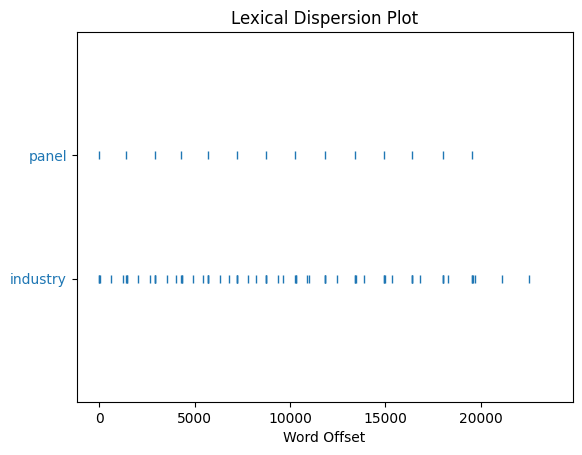

In [29]:
cyber_text.dispersion_plot(['panel','industry'])

### Frequency Distribution

In [52]:
# frequency distribution
frequency_distribution = FreqDist(lemmatized_text)

In [53]:
frequency_distribution.most_common(20)

[('attack', 384),
 ('vulnerability', 373),
 ('company', 306),
 ('malware', 305),
 ('campaign', 265),
 ('actor', 242),
 ('security', 238),
 ('threat', 226),
 ('flaw', 170),
 ('group', 140),
 ('could', 119),
 ('file', 114),
 ('attacker', 101),
 ('user', 101),
 ('software', 100),
 ('researcher', 98),
 ('``', 97),
 ("''", 97),
 ('new', 95),
 ('also', 94)]

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

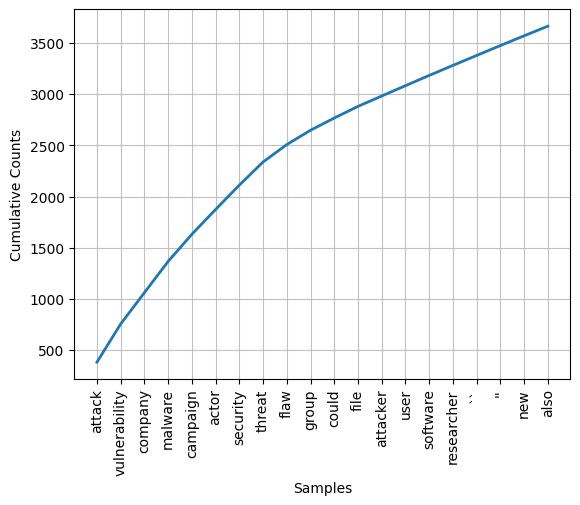

In [54]:
# Plot cumulative
frequency_distribution.plot(20, cumulative=True)

<Axes: xlabel='Samples', ylabel='Counts'>

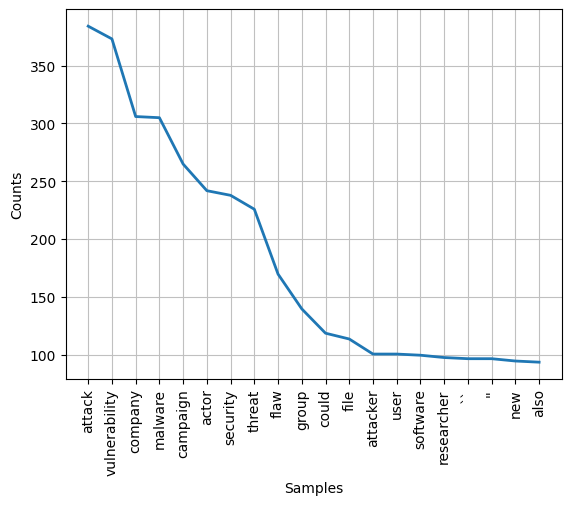

In [55]:
# Plot non-cumulative
frequency_distribution.plot(20, cumulative=False)